## Sección 0. Preparación del entorno

#### Importación de librerías

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import tensorflow as tf
import _pickle as pickle
import matplotlib.pyplot as plt

#### Montar unidad de disco Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%mkdir '/tmp/data'
%mkdir '/tmp/tfrecords'
%cp '/content/drive/MyDrive/TFM/UTKFace.tar.gz' '/tmp/UTKFace.tar.gz'

#### Definición de parámetros y rutas

In [ ]:
# FILE PATHS AND FILE NAMES
DATA_PATH = '/tmp/data/UTKFace'
TFRECORDS_PATH = '/tmp/tfrecords'
FIGS_PATH = '/content/drive/MyDrive/TFM/figs'

# DATA DEFINITIONS
alias = {0: 'male', 1: 'female'}

## Sección 1. Definición de funciones

##### Lectura de datos

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
  """
    Extracts features from file name and return it in a pd.DataFrame.

    Used to extract information about dataset from file names. It iterates over
    dataset_path and return a pandas DataFrame with age, gender and file path of
    all files.

    Parameters:
      dataset_path (str): path where images are stored
      ext (str): extensiong of image files
  
    Returns:
      pd.DataFrame: df with info about dataset
  """
  def parse_info_from_file(path):
    """
      Parses information from a single file
    """
    try:
      age, gender, _, _ = os.path.splitext(os.path.split(path)[1])[0].split('_')
      return int(age), int(gender)
    except Exception as ex:
      return None, None
        
  files = glob(os.path.join(dataset_path, "*.%s" % ext))
    
  records = []
  for f in files:
    info = parse_info_from_file(f)
    records.append(info)
      
  df = pd.DataFrame(records)
  df['file'] = files
  df.columns = ['age', 'gender', 'file']
  df = df.dropna().reset_index(drop=True)
  df = df.astype({'age': np.int64, 'gender': np.int64, 'file': str})
  
  return df

#### Parseado a TFRecord

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [ ]:
def serialize_example(row):
  """Creates a tf.train.Example message ready to be written to a file."""
  image = open(row['file'], 'rb').read()
  gender, age = row['gender'], row['age']
  feature = {
      'image': _bytes_feature([image]),
      'outputs': _int64_feature([gender, age])
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  
  return example_proto.SerializeToString()

In [ ]:
def create_tf_record(df, idx, fold, filename):
  """
    Creates a TFRecord file from data in `df` with indexes `idx` in `fold`
    folder and `filename` name. TFRecord file is stored in local storage at
    `TFRECORDS_PATH`.

    Parameters:
      df (pandas.DataFrame): all data is stored in here
      idx (np.array): indexes of data that will be stored in TFRecord file
      fold (str): folder insede `TFRECORDS_PATH` where TFRecord file is stored.
      filename (str): train, valid or test for naming TFRecord file accordingly.
  """
  file_path = os.path.join(TFRECORDS_PATH, f'fold{fold}')
  if not os.path.exists(file_path):
    os.makedirs(file_path)
  for i, block in enumerate(idx):
    with tf.io.TFRecordWriter(
        os.path.join(file_path, f'{filename}{i+1}.tfrecord')) as f:
        for id in block:
          f.write(serialize_example(df.loc[id]))

#### División en ficheros y distribución en k-folds

In [ ]:
def generate_files_split(N, k):
  """
    Data indexes are shuffled and Splitted into train set (60%), validation set
    (20%) and test set (20%) in blocks/files of 2155 images.

    Parameters:
      N (int): number of instances for building their indexes for reaching them
              from pandas.DataFrame
      k (int): number of files/folds to split data
    Return:
      numpy.array: indexes in blocks for train, validation and test sets.
  """
  n_train = round(k * 0.6)            # 60% train
  n_valid = n_train + round(k * 0.2)  # 20% valid
  n_test = n_valid + round(k * 0.2)   # 20% test
  # Shuffle index and fit then in 'num_files' blocks
  idx = np.random.default_rng().permutation(N)
  idx_blocks = idx.reshape(k, -1) # 2155 images per block
  train_blocks = idx_blocks[:n_train]         # 7 files * 2155 images
  valid_blocks = idx_blocks[n_train:n_valid]  # 2 files * 2155 images
  test_blocks = idx_blocks[n_valid:n_test]    # 2 files * 2155 images

  return train_blocks, valid_blocks, test_blocks

In [ ]:
def shift_file(train_idx, valid_idx, test_idx):
  """
    Makes a list from train, validation and test indexes in order to deal with
    data as a LIFO queue and build train, validation and test files. Indexes
    are returned as numpy.array.

    Parameters and return:
      train_idx (numpy.array): indexes of train set
      valid_idx (numpy.array): indexes of validation set
      test_idx (numpy.array): index of test set
  """
  train_l, valid_l, test_l = list(train_idx), list(valid_idx), list(test_idx)
  to_train, to_valid, to_test = valid_l.pop(0), test_l.pop(0), train_l.pop(0)
  train_l.append(to_train)
  valid_l.append(to_valid)
  test_l.append(to_test)
  
  return np.array(train_l), np.array(valid_l), np.array(test_l)

In [ ]:
def generate_kfold_split(N, k):
  """
    Takes N indexes from instances, shuffles and splits then into k folds/files.
    No instance is repeted in different files. Files will be created at
    `TFRECORDS_PATH` in different folders for each fold. Data is splitted in
    train, validation and test sets.

    Parameters:
      N (int): number of instances for building their indexes for reaching them
              from pandas.DataFrame
      k (int): number of files/folds to split data
  """
  for i in range(k): # data will be stored in k-fold (as much as num_files)
    if i == 0: # Generate indexes for first file/fold
      train_idx, valid_idx, test_idx = generate_files_split(N, k)
    else: # shift files for building k-fold datasets
      train_idx, valid_idx, test_idx = shift_file(train_idx, valid_idx, test_idx)
    # Store TFRrecord files for every fold 
    create_tf_record(df, train_idx, i, 'train') # Train TFRecord files
    create_tf_record(df, valid_idx, i, 'valid') # Validation TFRecord files
    create_tf_record(df, test_idx, i, 'test') # Test TFRecord files

#### Generación de Dataset

In [ ]:
def get_dataset(filenames):
  """Reads data from TFRecord and creates a tf.data.Dataset"""
  def parse_tfrecord(example):
    """Parse a single example"""
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "outputs": tf.io.FixedLenFeature([2], tf.int64)
    }
    tfrecord = tf.io.parse_single_example(example, features)

    image = tf.image.decode_jpeg(tfrecord['image'], channels=3)
    image = tf.reshape(image, (200, 200, 3))
    image = tf.image.resize(image, (200, 200))
    gender, age = tfrecord['outputs'][0], tfrecord['outputs'][1]

    return image, {'gender_output': gender, 'age_output': age}

  def load_dataset(filenames):
    """Read from TFRecord files and parse all data"""
    raw_dataset = tf.data.TFRecordDataset(filenames)
    parsed_dataset = raw_dataset.map(parse_tfrecord)
    return parsed_dataset

  return load_dataset(filenames)

## Sección 2. Adaptación de los datos al formato TFRecord

Carga de los datos

In [ ]:
import tarfile

file = tarfile.open('/tmp/UTKFace.tar.gz') 
file.extractall('/tmp/data/')
file.close() 

Distribución de los datos en ficheros TFRecord

In [ ]:
num_files = 11
df = parse_dataset(DATA_PATH) # Loads data in DataFrame
generate_kfold_split(len(df), num_files) # TFRecord files in local storage

Subir archivos a GCS

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'diesel-air-369317' # My project id
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://info-bucket-gcs-tfm/


In [ ]:
bucket_name = 'info-bucket-gcs-tfm' # My bucket name
!gsutil -m rm -r gs://{bucket_name}/*/*.tfrecord # Removes existing files
for k in range(num_files): # Copies TFRecord files from local to GCS
  !gsutil -m cp -r /tmp/tfrecords/fold{k}/*.tfrecord gs://{bucket_name}/fold{k}

CommandException: 1 files/objects could not be removed.
Copying file:///tmp/tfrecords/fold0/train4.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/train5.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/test2.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/test1.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/train1.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/train6.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/train2.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/valid1.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/train7.tfrecord [Content-Type=application/octet-stream]...
Copying file:///tmp/tfrecords/fold0/train3.tfrecord [Content-Type=application/octet-stream]

## Sección 3. Análisis de datos

#### Imágenes

In [ ]:
filenames = tf.io.gfile.glob(TFRECORDS_PATH + '/*')
ds = get_dataset(filenames[0])

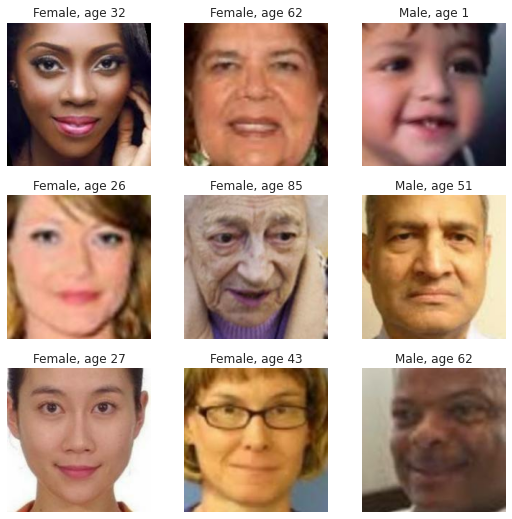

In [ ]:
plt.figure(figsize=(9, 9))
for i, (img, lab) in enumerate(ds.take(9)): # Take only 9 instances
  gender, age = lab['gender_output'], lab['age_output']
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img/255) # pixels between 0 and 1
  plt.title(f'{alias[gender.numpy()].capitalize()}, age {age}')
  plt.axis('off')
plt.savefig(os.path.join(FIGS_PATH, 'sample_dataset.png'), dpi=200)

In [ ]:
print('Image dimensions:', img.shape)
# Find min and max values
print(f"The minimum and maximum values for a pixel are {np.min(img):.0f}",
      f"and {np.max(img):.0f}.")

Image dimensions: (200, 200, 3)
The minimum and maximum values for a pixel are 0 and 255.


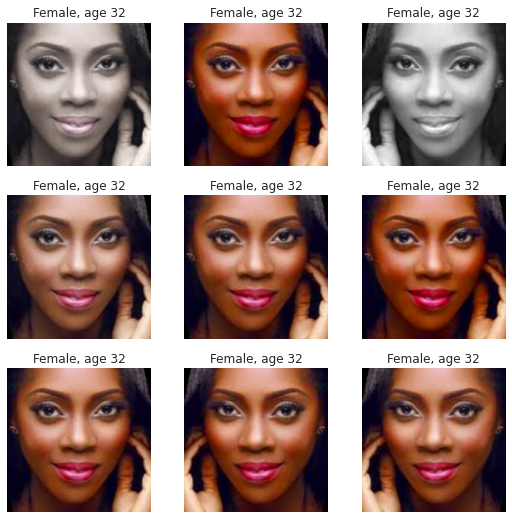

In [ ]:
# Data augmentation from first image: left and right flip and saturation
for i, (img, lab) in enumerate(ds.take(1)):
  plt.figure(figsize=(9, 9))
  gender, age = lab['gender_output'], lab['age_output']
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented = tf.image.random_flip_left_right(img/255)
    augmented = tf.image.random_saturation(augmented, 0, 2)
    plt.imshow(augmented)
    plt.title(f'{alias[gender.numpy()].capitalize()}, age {age}')
    plt.axis('off')
plt.savefig(os.path.join(FIGS_PATH, 'augmented_dataset.png'), dpi=200)

#### Etiquetas

Género

In [ ]:
# Categorical pandas DataFrame
df_cat = df.copy()
df_cat.loc[(df.gender == 0), 'gender'] = 'male'
df_cat.loc[(df.gender == 1), 'gender'] = 'female'

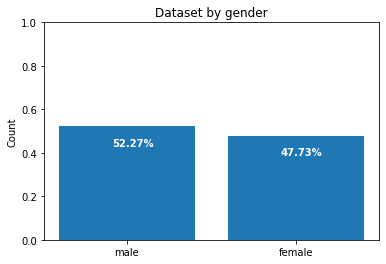

Total male: 12391, total female: 11314


In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

labels = df_cat.value_counts('gender', normalize=True).index
values = df_cat.value_counts('gender', normalize=True).values
ax.bar(labels, values)
ax.set_ylim([0, 1])
ax.set_title('Dataset by gender')
ax.set_ylabel('Count')
ax.grid(False)
for i, v in enumerate(values):
    ax.text(i - 0.09, v - 0.09, f'{v:.2%}', fontweight='bold',  color='white')
plt.show()
fig.savefig(os.path.join(FIGS_PATH, 'dataset_by_gender.png'), dpi=200)

print('Total male: {:.0f}, total female: {:.0f}'.format(*values*len(df_cat)))

Edad

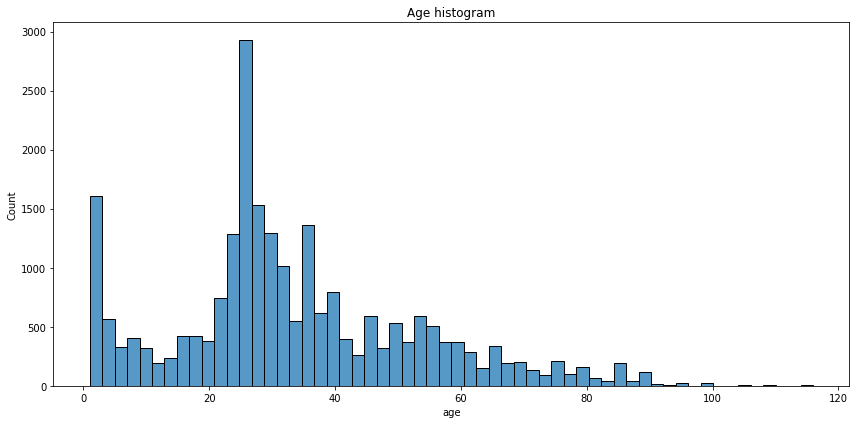

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df, x="age", bins=58, ax=ax)
ax.set(title='Age histogram')
plt.tight_layout()
fig.savefig(os.path.join(FIGS_PATH, 'age_histogram.png'), dpi=200)

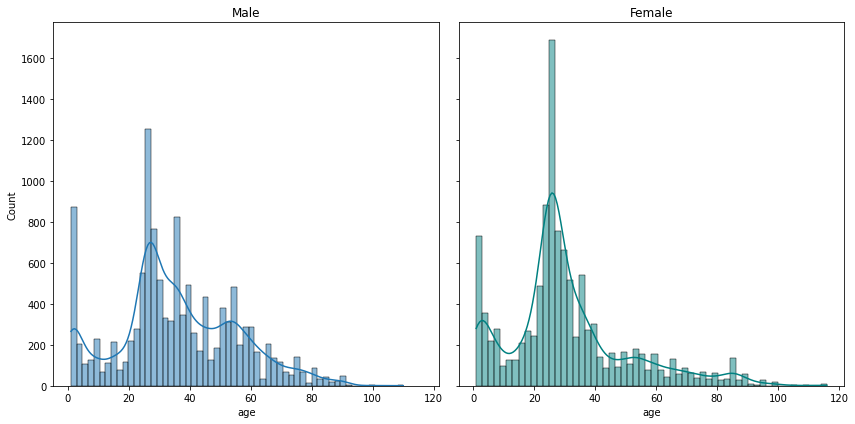

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
sns.histplot(df[df.gender == 0], x="age", kde=True, bins=58, ax=ax1)
sns.histplot(df[df.gender == 1], x="age", kde=True, bins=58, color = 'teal', ax=ax2)
ax1.set_title('Male')
ax2.set_title('Female')
plt.tight_layout()
fig.savefig(os.path.join(FIGS_PATH, 'age_distribution_by_gender.png'), dpi=200)

In [ ]:
# Show first 15 most frequently years in age feature
df.groupby('age').count().sort_values('gender', ascending=False).gender.head(15)

age
26    2197
1     1123
28     918
35     880
24     859
25     734
30     724
32     664
27     615
29     570
40     526
36     483
2      482
45     440
23     426
Name: gender, dtype: int64

In [ ]:
max_age, min_age = max(df.age), min(df.age)
print(f'Maximum and minimum age are {max_age} and {min_age}')

Maximum and minimum age are 116 and 1


In [ ]:
# Store in pickle file max and min age to be used in other notebooks
pickle_file = '/content/drive/MyDrive/TFM/age_scaler.pickle'
with open(pickle_file, 'ab') as f:
  pickle.dump({'max_age': max_age, 'min_age': min_age}, f)